##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

<div>
<img src="../vensim_models/inventory/inven_1est_invenadjtime.png" width="800"/>
</div>



## user interface

In [16]:
sbc.observed_data

<xarray.Dataset>
Dimensions:            (prior_draw: 1, time: 20)
Coordinates:
    chain              (prior_draw) int64 ...
    draw               (prior_draw) int64 ...
  * time               (time) float64 0.01 0.51 1.01 1.51 ... 8.51 9.01 9.51
Dimensions without coordinates: prior_draw
Data variables:
    stocked_ping_obs   (time, prior_draw) float64 ...
    stocked_pping_obs  (time, prior_draw) float64 ...
Attributes: (4)

In [41]:
setting = {
    "est_param_names" : ["adj_frac1_loc", "adj_frac2_loc",  "adj_frac1", "adj_frac2"], #"adj_frac3"], # "ss2p_frac4"],# "ss2p_frac4"
    "hier_est_param_names": ["adj_frac1", "adj_frac2"],#, "adj_frac3"],# "ss2p_frac4"],
    "target_sim_vector_names" : ["stocked_ping", "stocked_pping"],
    "driving_vector_names" : ["exog_demand", "process_noise_normal_driving"],
    "model_name": "2hier_s_norm_pn1_saveper"
}

In [1]:
import xarray as xr
from scipy.stats import lognorm
from stanify.calibrator.visualizer import plot_sbc_rank, plot_sbc_ecdf
import arviz as az
import numpy as np
sbc = az.from_netcdf(f"data/inven_share_bmajor_ln_S2N20Q2P1H0R1_M100_ps0.1/sbc_4est_pnoise0.0.nc")
precision ={
    "S": 2,
    "M": 1000,
    "N": 20,
    "R": 1
}
setting = {
    "est_param_names" : ["adj_frac1", "adj_frac2"],
    "hier_est_param_names": [],
    "target_simulated_vector_names" : ["stocked_ping", "stocked_pping"],
    "driving_vector_names" : ["exog_demand", "process_noise_normal_driving"],
    "model_name": "a"
}
def compute_loglik_rank(target_sim_vector_prior:xr.DataArray, m_noise_scale_prior: np.ndarray, observed_data,
                        target_sim_vector_post:xr.DataArray, m_noise_scale_post:np.ndarray, S:int): #, data_index=0, chain_index=0):
    sbc_rank = []
    loglik_prior = []
    loglik_post = []
    for s in range(S):
        loglik_prior = lognorm.logpdf(observed_data, m_noise_scale_prior.sel(prior_draw=s).values,
                                      target_sim_vector_prior.sel(prior_draw=s).values)
        loglik_post  = lognorm.logpdf(observed_data, m_noise_scale_post.sel(prior_draw=s).values,
                                      target_sim_vector_post.sel(prior_draw=s).values)

        sbc_rank.append(sum(loglik_post < loglik_prior))
        loglik_prior.append(loglik_prior) # length S [.1, .3, .4]
        loglik_post.append(loglik_post) # length S [0, .2, .4]
    return sbc_rank, loglik_prior, loglik_post


idata = sbc
loglik_prior = []
loglik_post = []
for target_sim_vector_name in setting['target_sim_vector_names']:
    rank, loglik_prior_q, loglik_post_q = compute_loglik_rank(idata.prior[target_sim_vector_name], idata.prior["m_noise_scale"],
                idata.observed_data[f'{target_sim_vector_name}_obs'], idata.posterior[target_sim_vector_name], idata.posterior["m_noise_scale"], precision['S'])
    plot_sbc_rank(rank, target_sim_vector_name)
    loglik_prior = [sum(i) for i in zip(loglik_prior, loglik_prior_q)]
    loglik_post = [sum(i) for i in zip(loglik_post, loglik_post_q)]
sbc_rank = sum([i<j for i,j in zip(loglik_prior, loglik_post)])
compute_loglik_rank(sbc_rank, "all")


FileNotFoundError: [Errno 2] No such file or directory: b'data/inven_share_bmajor_ln_S2N20Q2P1H0R1_M100_ps0.1/sbc_4est_pnoise0.0.nc'

In [1]:
import numpy as np
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_util import check_consistency
np.random.seed(10)
import warnings
warnings.filterwarnings('ignore')

precision ={
    "S": 1,
    "M": 10,
    "N": 20,
    "R": 1
}
setting = {
    "est_param_names" : ["adj_frac1", "adj_frac2"],
    "hier_est_param_names": [],
    "target_sim_vector_names" : ["stocked_ping", "stocked_pping"],
    "driving_vector_names" : ["exog_demand", "process_noise_normal_driving"],
    "model_name": "refactor"
}
init_order = 100
# driving data
numeric = {
        "exog_demand": np.sin(np.arange(0, precision['N'])*100000) * init_order * .5 + init_order,
        "process_noise_normal_driving": np.random.normal(0, 1, size=precision['N']),
        'process_noise_scale': .1
}

prior = [
    ("adj_frac1", "normal", .25, .25 *.1, 0),
    ("adj_frac2", "normal", .125,.125 *.1, 0),
    ("m_noise_scale", "lognormal", 1, .1, 0) #use true mean notation, instead of log(mean) notation
]

output_format = dict(
    prior_predictive=["stocked_ping_obs", "stocked_pping_obs"],
    posterior_predictive=["stocked_ping_obs_post", "stocked_pping_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_sim_vector_names'],
        "region": [r for r in range(precision['R'])]
    },

    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        "stocked_ping_obs": ["time"],
        "stocked_pping_obs": ["time"],
        "stocked_ping_obs_post": ["time"],
        "stocked_pping_obs_post": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    idata_orig, model = draws2data2draws('../vensim_models/inventory/hier2_flow.mdl', setting, precision, numeric, prior, output_format)

10:02:27 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data
10:02:35 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data
10:02:35 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
10:02:35 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/refactor_S1N20Q2P2H0R1_M10_ps0.1/draws2data.s

chain 1 |          | 00:00 Status

10:02:35 - cmdstanpy - INFO - CmdStan done processing.



init_draws_dict:  {'adj_frac1': <xarray.DataArray 'adj_frac1' ()>
array(0.273813)
Coordinates:
    chain    int64 0
    draw     int64 0, 'adj_frac2': <xarray.DataArray 'adj_frac2' ()>
array(0.123309)
Coordinates:
    chain    int64 0
    draw     int64 0}


TypeError: argument of type 'NoneType' is not iterable

We load produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`, `observed_data`. First click the arrow below to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `osberved_data` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [3]:
sbc = az.from_netcdf(f"data/2hier_s_norm_pn1_saveper_S1N20Q2P2H0R1_M100_ps1/sbc_2est_pnoise1.nc")
init_draws_dict = {
    **sbc.prior
}
init_draws_dict

{'adj_frac1': <xarray.DataArray 'adj_frac1' (prior_draw: 1)>
 [1 values with dtype=float64]
 Coordinates:
     chain    (prior_draw) int64 ...
     draw     (prior_draw) int64 ...
 Dimensions without coordinates: prior_draw,
 'adj_frac2': <xarray.DataArray 'adj_frac2' (prior_draw: 1)>
 [1 values with dtype=float64]
 Coordinates:
     chain    (prior_draw) int64 ...
     draw     (prior_draw) int64 ...
 Dimensions without coordinates: prior_draw,
 'm_noise_scale': <xarray.DataArray 'm_noise_scale' (prior_draw: 1)>
 [1 values with dtype=float64]
 Coordinates:
     chain    (prior_draw) int64 ...
     draw     (prior_draw) int64 ...
 Dimensions without coordinates: prior_draw,
 'b': <xarray.DataArray 'b' (b_dim_0: 20, prior_draw: 1)>
 [20 values with dtype=float64]
 Coordinates:
     chain    (prior_draw) int64 ...
     draw     (prior_draw) int64 ...
   * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
 Dimensions without coordinates: prior_draw,
 'eor': <xarra

In [12]:

sbc.prior

<xarray.Dataset>
Dimensions:              (prior_draw: 1, b_dim_0: 20, eor_dim_0: 20,
                          process_noise_dim_0: 20, s_dim_0: 20, ss_dim_0: 20,
                          stocked_ping_dim_0: 20, stocked_pping_dim_0: 20,
                          time: 20, stock: 7)
Coordinates:
    chain                (prior_draw) int64 ...
    draw                 (prior_draw) int64 ...
  * b_dim_0              (b_dim_0) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * eor_dim_0            (eor_dim_0) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * process_noise_dim_0  (process_noise_dim_0) int64 0 1 2 3 4 ... 16 17 18 19
  * s_dim_0              (s_dim_0) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * ss_dim_0             (ss_dim_0) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * stocked_ping_dim_0   (stocked_ping_dim_0) int64 0 1 2 3 4 ... 15 16 17 18 19
  * stocked_pping_dim_0  (stocked_pping_dim_0) int64 0 1 2 3 4 ... 16 17 18 19
  * time                 (time) float64 0.01 0.51 1.01 1.51 ... 8.51 9.01 9.51
  * stock                (stock) object 'b' 'eor' ... 'stocked_pping'
Dimensions without coordinates: prior_draw
Data variables:
    adj_frac1            (prior_draw) float64 ...
    adj_frac2            (prior_draw) float64 ...
    m_noise_scale        (prior_draw) float64 ...
    b                    (b_dim_0, prior_draw) float64 ...
    eor                  (eor_dim_0, prior_draw) float64 ...
    process_noise        (process_noise_dim_0, prior_draw) float64 ...
    s                    (s_dim_0, prior_draw) float64 ...
    ss                   (ss_dim_0, prior_draw) float64 ...
    stocked_ping         (stocked_ping_dim_0, prior_draw) float64 ...
    stocked_pping        (stocked_pping_dim_0, prior_draw) float64 ...
    integrated_result    (time, stock, prior_draw) float64 ...
Attributes: (4)

In [16]:
sbc.prior[['adj_frac1', 'adj_frac2']].items().tolist()

AttributeError: 'ItemsView' object has no attribute 'tolist'

In [15]:
sbc.prior.tolist()

AttributeError: 'Dataset' object has no attribute 'tolist'

In [12]:
sbc.prior[['adj_frac1', 'adj_frac2']].values().tolist()

AttributeError: 'ValuesView' object has no attribute 'tolist'

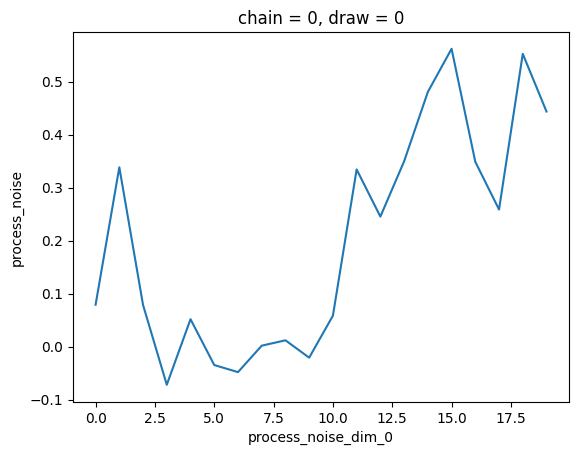

In [4]:
sbc.prior['process_noise'].plot()

In [1]:
np.std(sbc.prior['process_noise'].values)

NameError: name 'np' is not defined

In [6]:
sbc.posterior['process_noise'].values

array([[[[0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         ...,
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ]],

        [[0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         ...,
         [0.0789071, 0.338185 , 0.0783916, ..., 0.258576 , 0.552174 ,
          0.443393 ],
         [0.0789071, 0.338185 , 0.0783916, ..., 0.

In [7]:
np.std(sbc.prior['process_noise'].values)

0.20803550013317587

In [8]:
np.std(sbc.posterior['process_noise'].values.flatten())

0.20803550013317587

In [11]:
np.std(sbc.posterior['process_noise'].values.flatten())

0.027381449636864674

<AxesSubplot: >

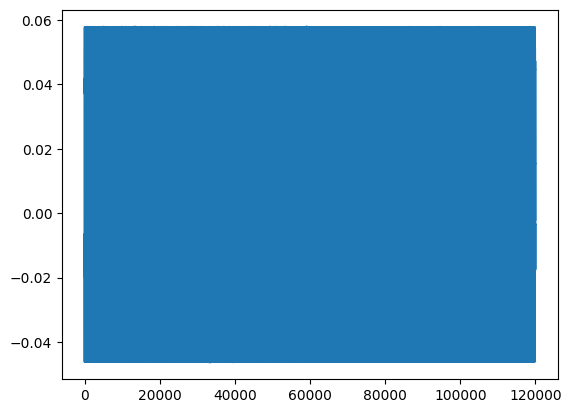

In [9]:
pd.Series(sbc.posterior['process_noise'].values.flatten()).plot()

In [ ]:
np.sbc.prior_predictive['process_noise_obs'].values() #.1

Posterior is very tight without much uncertainty

In [ ]:
az.plot_posterior(sbc, var_names=setting['est_param_names'])

The [forest plot](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) shows chains are stuck. Generally, each chain has different values, so plot_posterior that combines gives a semblance of kde, but for this model, each chain returns always the same exact value.

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details. From large number of r_hat, the covergence of four chains are not good which is verified in more detail below. 1.2 is the usual threshold for r_hat.

In [ ]:
az.summary(sbc.posterior[setting['est_param_names']])

In [ ]:
az.summary(sbc.posterior['m_noise_scale'])

The PPC (prior/poseterior predictive check) plot is a standard way for Bayesian checking. It serves complementary role with simulation-based calibration (SBC). Two checks happen in different space: PPC in observation space as time series, SBC in parameter space as rank comparison between the ground truth and retrieved estimated samples. From the plot, posterior predictive's negative values is the most problematic which was expected as the currrent version uses normal likelihood. Changing this to lognoraml or negative binomial can solve this problem, but lognormal has thicker tail creating difficult posterior geometry and negative binomial need transformation to integer value which is known to be not accurate.

new plot that compares against time is needed for dynamic models. posterior predictive is quite different from general bayse models.

In [ ]:
data_pairs = dict()
for obs_name in output_format['prior_predictive']:
    data_pairs[obs_name] = f'{obs_name}_post'
az.plot_ppc(sbc, data_pairs = data_pairs)

# loglikliehood plots

# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{model.model_name}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{model.model_name}/data2draws.stan").code())